In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import pipeline_plan_functions.utils.pipe_db_handler as dbh
import pipeline_plan_functions.utils.data_types as dth
from python_utils.utils.logger import logger
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import matplotlib
import pickle
# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')
FPS_COLOURS = ['#004A9C', '#45D281', '#FEC001', '#A365E0', '#5B9BD5',
               '#FF0000', '#0563C1', '#954F72']

In [2]:
specs = (101, 102, 115, 116, 117)
good_sites = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17, 20, 22, 28]
tru_spec_dict = {
    101: 1,
    102: 2,
    115: 3,
    116: 4,
    117: 5
}
XPOWER = 0.98
MAX_SHOREPOWER_HOURS = 5.38  # hours
NEW_SHOREPOWER_HOURS = 5.5  # hours
CHARGER_EFF = 0.9
BATTERY_USABLE = 0.8
DEFAULT_WAIT = 8  # HOURS
tru_battery_kwh = [30*BATTERY_USABLE, 24*BATTERY_USABLE, 19*BATTERY_USABLE, 14*BATTERY_USABLE]
tru_battery_dict = {'Future': 30*BATTERY_USABLE, 'Long range': 24*BATTERY_USABLE,
                    'Medium range': 19*BATTERY_USABLE, 'Short range': 14*BATTERY_USABLE}
tru_charger_kw = 9
remove_charging_time = 0.5
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']
tru_specs = ff.find_tru_spec((1, 2, 3, 4, 5))
vehicle_specifications['tru_id'] = vehicle_specifications.index.map(tru_spec_dict)
vehicle_specifications = vehicle_specifications.reset_index()
vehicle_specifications = vehicle_specifications.merge(
    tru_specs,
    left_on='tru_id', right_on='tru_id', how='left')
vehicle_specifications = vehicle_specifications.set_index('spec_id')
good_specs = vehicle_specifications['vehicle_model'].to_dict()
site_dict = ff.get_site_name_dict(2)

sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
cnx = dbh.create_alch_engine()
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
vehicle_ref_dict = vehicle_df['refrigerated'].to_dict()
cnx.dispose()

In [3]:
def create_time_periods(start, end, delta):
    N = (end - start) / delta + 1
    wave_times = (np.arange(N) * delta) + start
    return wave_times

def site_vehicle_availability(routes, N, vehicles):
    # create empty availability matrix
    availability_matrix = np.zeros((N, len(vehicles)))
    # Fill availability matrix with routes for each vehicle
    for idx in routes_sites.index:
        tp_start = routes.loc[idx, 'start_shorepower_tp']
        tp_end = routes.loc[idx, 'end_shorepower_tp']
        vehicle_idx = vehicles.index(routes.loc[idx, 'vehicle_id'])
        availability_matrix[tp_start: tp_end, vehicle_idx] += 1
    return availability_matrix


## Modelling

### Supplier runs

In [35]:
cnx = dbh.create_alch_engine()
sql_query = """SELECT departure_time, arrival_time, vehicle_id, distance_miles,
    departure_location, arrival_location, departure_site_id, arrival_site_id, route_id FROM t_telematics WHERE run = 44"""
telematics = pd.read_sql_query(sql_query, con=cnx)
telematics['depot'] = telematics['departure_site_id'].isin(good_sites)
telematics['spec_id'] = telematics['vehicle_id'].map(vehicle_spec_dict)
# telematics.groupby('departure_location')['vehicle_id'].count().sort_values().to_csv('sample/tru2/count_entries.csv')

In [36]:
# Calculate how long the vehicle has been on a site
telematics.sort_values(by=['vehicle_id', 'departure_time'], inplace=True)
telematics['depot_stay'] = (telematics['departure_time']
                            - telematics['arrival_time'].shift(1))/dt.timedelta(hours=1)
mask_change_veh = telematics['vehicle_id'] != telematics['vehicle_id'].shift(1)
telematics.loc[mask_change_veh, 'depot_stay'] = 0
mask_weird_site = telematics['departure_location'] != telematics['arrival_location'].shift(1)
telematics.loc[mask_weird_site, 'depot_stay'] = 0

In [37]:
# Find non depot locations where the vehicle stays for long
stay_hours_limit = 3
other_common_locations = [
       'Belfast DC', 'Argos Heywood DC', 'Argos Kettering',
       'NFT Bristol (Chill Hub)', 'NFT Crick (Chill Hub)', 'Pindar Road DC',
       'Basingstoke VMU', 'Patchway PCC', 'Argos Basildon DC', 'Bedford DC',
       'Stoke DC']
mask_odd_stay = ((~telematics['depot'])
                 & (telematics['depot_stay'] > stay_hours_limit)
                 & (~telematics['departure_location'].isin(other_common_locations)))
telematics['odd_stay'] = mask_odd_stay
location_count = telematics[mask_odd_stay].groupby('arrival_location').agg({
    'departure_site_id': 'count',
    'vehicle_id': 'nunique'
})
routes = telematics.groupby('route_id').agg({
    'departure_time': 'first',
    'arrival_time': 'max',
    'vehicle_id': 'first',
    'departure_location': 'first',
    'arrival_location': 'last',
    'depot': 'mean',
    'odd_stay': 'any'
})
# Find how often this happens
print('% telematics: ', telematics['odd_stay'].mean())
print('% : routes', routes['odd_stay'].mean())

% telematics:  0.01918225538232419
% : routes 0.05373048194936254


In [38]:
# Create suply return routes
# Create return routes starting with each odd stay
new_veh = telematics['vehicle_id'].shift(1) != telematics['vehicle_id']
new_journey = telematics['odd_stay'] | new_veh
telematics['supply_route'] = new_journey.astype(int).cumsum()
# Remove from the supply returns the telematics moves after a depot
# Cummulative of depot stays per telematics entry
depot_cumulative = telematics['depot'].cumsum() + 1
# Get the depot count at the start of each supply route for each move in a supply route
start_depot_count = depot_cumulative * telematics['odd_stay']
start_depot_count[start_depot_count == 0] = np.nan
start_depot_count = start_depot_count.fillna(method='ffill').fillna(0)
# Find the moves that have a higher depot count than at the start of the route and assing route 0
moves_out_of_route = depot_cumulative > start_depot_count
telematics.loc[moves_out_of_route, 'supply_route'] = 0
# Create the supply routes
supply_routes = telematics.groupby('supply_route').agg({
    'departure_time': 'first',
    'arrival_time': 'max',
    'vehicle_id': 'first',
    'spec_id': 'first',
    'departure_location': 'first',
    'arrival_location': 'last',
    'arrival_site_id': 'last',
    'depot': 'any',
    'depot_stay': 'first',
    'odd_stay': 'any'
})
# Filter by lenth and arriving at depot
arrive_at_depot = supply_routes['arrival_site_id'].isin(good_sites)
supply_routes['duration'] = (supply_routes['arrival_time']
                             - supply_routes['departure_time'])/dt.timedelta(hours=1)
mask_trailers = supply_routes['spec_id'].isin([115, 116, 117])
refrigerated_route = supply_routes['vehicle_id'].map(vehicle_ref_dict)
supply_routes = supply_routes[refrigerated_route & arrive_at_depot & mask_trailers
                              & (supply_routes['duration'] < 10)]

In [39]:
# Assign shore power energy to each route
shore_hours = supply_routes['depot_stay'].clip(upper=MAX_SHOREPOWER_HOURS)
shore_kw_summer = supply_routes['spec_id'].map(
    vehicle_specifications['shorepower_summer_kw'].to_dict())
supply_routes['shore_energy_kwh'] = shore_hours * shore_kw_summer
# Assing route energy consumption per route
route_kw_summer = supply_routes['spec_id'].map(
    vehicle_specifications['route_power_summer_kw'].to_dict())
supply_routes['route_energy_kwh'] = supply_routes['duration'] * route_kw_summer
# Calculate battery feasibility
supply_routes['total_energy_kwh'] = supply_routes['route_energy_kwh'] + supply_routes['shore_energy_kwh']
supply_routes['battery_choice'] = 100
for battery in tru_battery_kwh:
    mask_feasible_battery = supply_routes['total_energy_kwh'] <= battery
    supply_routes.loc[mask_feasible_battery, 'battery_choice'] = battery

In [40]:
df = supply_routes.groupby('battery_choice')[['departure_time']].count()
df['battery choice'] = df.index.map({tru_battery_dict[key]: key for key in tru_battery_dict.keys()})
df.reset_index(inplace=True)
df.columns = ['battery cap kW', 'count', 'battery choice']
df['% covered'] = np.round(100*df['count']/df['count'].sum(), 1)
df

,battery cap kW,count,battery choice,% covered
0,11.2,70,Short range,0.5
1,15.2,1891,Medium range,14.4
2,19.2,2477,Long range,18.9
3,24.0,5321,Future,40.6
4,100.0,3353,NaN,25.6


#### outputs

In [13]:
for i in range(10, 20):
    route = np.random.choice(routes[routes['odd_stay']].index)
    v = routes.loc[route, 'vehicle_id']
    departure = routes.loc[route, 'departure_time']
    cols = ['departure_location', 'depot_stay', 'departure_time', 'odd_stay']
    sample_tel = telematics[(telematics['vehicle_id'] == v)
            & (telematics['departure_time'] >= departure)][cols]
    sample_tel.to_csv(f'../../tru_sp_functions/outputs/tru2/sample_supply_route{i}.csv')

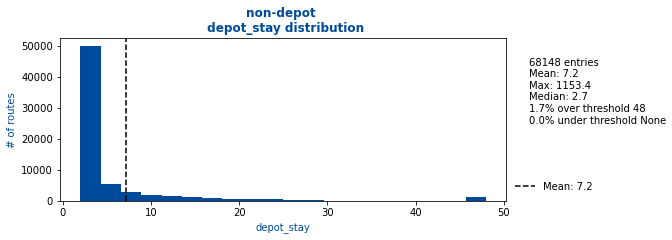

In [7]:
# Histo of stop duration
telematics[telematics['odd_stay']]
ff.histo_variable(telematics[telematics['odd_stay']], 'depot_stay', 'non-depot', upperclip=48,
                   lowerclip=None, bins=20, folder="tru2",
                   suff=f'{stay_hours_limit}h', vline_dict=None, title_text=None,
                   plot_mean=True, cumdist=False)

### Simultaneous chargers (charging + shore power)
This creates the master table and gets all the route data

In [239]:
# Get an allocation and a scenario master table. For each site get the following tables
alloc_run = 204
shorepower_run = 205
cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
allocation_ids = alloc_table.index
sql_query = f"select * from t_charging_scenarios where allocation_id IN {tuple(allocation_ids)} order by allocation_id, scenario_id"
scenarios = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()
connection, cur = dbh.database_connection('test')
inputs = dh.get_inputs('t_run_allocation', alloc_run, connection, cur)
cur.close()
connection.close()
# get availability matrix
availability_matrix = pickle.load(open(r'sample/tru/availability_matrix.pkl', 'rb'))
cols_alloc = ['run_id', 'site_id', 'vehicle1', 'num_r', 'num_v']
cols_scen = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'charger1']
cols_sp = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'num_charger1']
mask_charging = scenarios['run_id'] == alloc_run
mask_shorepower = scenarios['run_id'] == shorepower_run
master_table = alloc_table[cols_alloc].merge(scenarios[mask_charging][cols_scen],
                                             left_index=True, right_on='allocation_id',
                                             suffixes=("_alloc", "_ch"))
master_table = master_table.merge(scenarios[mask_shorepower][cols_sp],
                                  left_on='allocation_id', right_on='allocation_id',
                                             suffixes=("_charging", "_shorepower"))
master_table['site_name'] = master_table['site_id'].map(site_dict)
master_table['group'] = master_table['vehicle1'].map(good_specs)
master_table['simult_shorepower'] = availability_matrix.max(axis=1)
master_table.set_index('allocation_id', inplace=True)
master_table['simultaneous_chargers'] = 0
# Sort out the routes
routes_cleaned = pickle.load(open('sample/tru/routes_cleaned.pkl', 'rb'))
# Create a baseline HH vector covering the whole period
start_dt = inputs['start_date'] + dt.timedelta(hours=6)
end_dt = inputs['end_date'] + dt.timedelta(hours=6)
N = int((end_dt - start_dt)/dt.timedelta(hours=0.5))
times = start_dt + np.arange(N) * dt.timedelta(minutes=30)
# calculate start/end time periods per route
routes_cleaned['end_depot_time'] = (routes_cleaned['arrival_time']
                                    + pd.to_timedelta(routes_cleaned['next_wait_onsite'], unit='h'))
routes_cleaned['start_shorepower'] = (routes_cleaned['end_depot_time']
                                      - pd.to_timedelta(routes_cleaned['shorepower_time'], unit='h'))
routes_cleaned['start_shorepower_tp'] = np.round((routes_cleaned['start_shorepower']-start_dt)
                                                 /dt.timedelta(hours=0.5)).astype(int)
routes_cleaned['end_shorepower_tp'] = np.round((routes_cleaned['end_depot_time']-start_dt)
                                                 /dt.timedelta(hours=0.5)).astype(int)
routes_cleaned.sort_values(by=['vehicle_id', 'departure_time'], inplace=True)
routes_cleaned.reset_index(inplace=True)

2022-07-26 20:36:53|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 204


#### Charging
* Read the charge table for all scenarios for a site
* Convert to a bool matrix
#### Shore power
* Read routes for a site (all vehicle types)
* Create an availability matrix for each vehicle/time period
* Iterate over routes and assign the availability vector to each vehicle instead of the allocation
#### Combined charging
* Add both shore power and charging table and count how many are positive for each time period

In [241]:
for site in good_sites[:]:
        # Read charging table for the site
        mask_site = master_table['site_id'] == site
        site_scenarios = master_table.loc[mask_site, 'scenario_id_charging'].values
        sql_query = f"select datetime, allocated_vehicle_id, power_demand_kw from t_charge_demand where scenario_id IN {dth.list_to_string(site_scenarios)}"
        charge_table = pd.read_sql_query(sql_query, con=cnx)
        # Calculate how many vehicles are charging per hh
        charge_table['charging'] = (charge_table['power_demand_kw'] > 0).astype(int)
        charge_matrix = charge_table.set_index(['datetime', 'allocated_vehicle_id'])['charging'].unstack()
        charge_matrix.fillna(0, inplace=True)
        vehicles = charge_matrix.columns
        charge_array = charge_matrix.values
        # select site routes
        cols = ['spec_id', 'start_shorepower_tp', 'end_shorepower_tp',
                'shorepower_kwh', 'date', 'vehicle_id']
        routes_sites = routes_cleaned[routes_cleaned['site_id_end'] == site][cols]
        # Create availability matrix
        shorepower_availability = site_vehicle_availability(routes_sites, N, list(vehicles))
        # Fixes the length of the charge matrix if it's missing times
        if len(charge_matrix) < len(shorepower_availability):
                before_rows = int((charge_matrix.index[0] - times[0]) / dt.timedelta(hours=0.5))
                after_rows = int((times[-1] - charge_matrix.index[-1]) / dt.timedelta(hours=0.5))
                before_array = np.zeros((before_rows, len(vehicles)))
                after_array = np.zeros((after_rows, len(vehicles)))
                charge_array = np.vstack((before_array, charge_matrix.values, after_array))
        # Combine both availability matrices
        charger_demand = charge_array + shorepower_availability
        n_chargers = (charger_demand > 0).sum(axis=1).max()
        print(site, charger_demand.shape, n_chargers)
        master_table.loc[mask_site, 'simultaneous_chargers'] = n_chargers
        pickle.dump(charger_demand, open(f'sample/tru2/charger_demand_{site}.pkl', 'wb'))
pickle.dump(master_table, open(f'sample/tru2/scenario_table_with_simultaneous.pkl', 'wb'))
master_table.to_csv('sample/tru2/scenario_table_with_simultaneous.csv')


1 (3744, 1347) 99
2 (3744, 1327) 86
3 (3744, 1234) 81
4 (3744, 1225) 91
5 (3744, 1297) 95
6 (3744, 1080) 94
7 (3744, 1034) 79
8 (3744, 1067) 64
9 (3744, 691) 59
10 (3744, 829) 37
12 (3744, 886) 99
17 (3744, 980) 20
20 (3744, 850) 84
22 (3744, 924) 20
28 (3744, 201) 7


### Recalculate charge energy values

In [64]:
# Get original scenario table
# original_scenarios = pd.read_csv('sample/tru2/backups_220702/t_charging_scenarios.csv', index_col='scenario_id')
TIME_FRACT = 0.5
bad_scenarios = [1003, 1008, 1013, 1018, 1023, 1024, 1046, 1050, 1051]
# cnx = dbh.create_alch_engine()
# connection, cur = dbh.database_connection('test')
# Iterate over the key scenarios
for scenario in bad_scenarios[-1:]:
    print('Scenario:', scenario)
    # Load the scenario charger demand
    sql_query = f"select sum(power_demand_kw) from t_charge_demand where scenario_id = {scenario}"
    cur.execute(sql_query)
    connection.commit()
    demand_sum = cur.fetchall()
    # Calculate output kWh
    output_kwh = demand_sum[0][0] * TIME_FRACT
    # print output kWh vs original value
    print(f"Old: {original_scenarios.loc[scenario, 'output_kwh']}, new: {output_kwh}")
    # Update scenario table with new value
    sql_query =  f"update t_charging_scenarios set output_kwh = {output_kwh} where scenario_id = {scenario}"
    cur.execute(sql_query)
    connection.commit()
# cur.close()
# connection.close()

Scenario: 1051
Old: 14183.520085679012, new: 14139.317190617283


### Shore power calculations

In [185]:
# Load template shorepower
template_shore_power = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\tru/template_shorepower_aug2022.csv',
                                   usecols=['minutes', 'power_kw'], index_col='minutes')
# Scale shore power profile to each spec based on summer average shore power requirements
shore_profiles = {}
for spec in vehicle_specifications.index:
    scale_factor = (MAX_SHOREPOWER_HOURS / NEW_SHOREPOWER_HOURS) * (vehicle_specifications.loc[spec, 'shorepower_summer_kw'] / template_shore_power['power_kw'].mean())
    shore_profiles[spec] = template_shore_power * scale_factor

#### based on departure times

In [131]:
SHORE_MINUTES = 5  # interval time in minutes of the shore power profile
RUN = 207
alloc_run = 204
scenario_id = 1169  # Where to start the new scenarios

# Get routes and allocations
# connection, cur = dbh.database_connection('test')

cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
cnx.dispose()
allocation_ids = alloc_table.index
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
inputs = dh.get_inputs('t_run_allocation', alloc_run, connection, cur)
# Create a baseline HH vector covering the whole period
start_dt = inputs['start_date']
end_dt = inputs['end_date'] + dt.timedelta(hours=6)
N = int((end_dt - start_dt)/dt.timedelta(minutes=SHORE_MINUTES))
times = start_dt + np.arange(N) * dt.timedelta(minutes=SHORE_MINUTES)

# calculate start/end time periods per route
routes_cleaned['end_depot_time'] = (routes_cleaned['arrival_time']
                                    + pd.to_timedelta(routes_cleaned['next_wait_onsite'], unit='h'))
routes_cleaned['shorepower_time'] = routes_cleaned['next_wait_onsite'].clip(upper=NEW_SHOREPOWER_HOURS)
routes_cleaned['start_shorepower'] = (routes_cleaned['end_depot_time']
                                      - pd.to_timedelta(routes_cleaned['shorepower_time'], unit='h'))
routes_cleaned['arrival_tp'] = np.round((routes_cleaned['arrival_time']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
routes_cleaned['start_shorepower_tp'] = np.round((routes_cleaned['start_shorepower']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
routes_cleaned['end_shorepower_tp'] = np.round((routes_cleaned['end_depot_time']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
availability_matrix = np.zeros((len(allocation_ids), N))
onsite_matrix = np.zeros((len(allocation_ids), N))
# iterate over allocations
for i, idx in enumerate(allocation_ids[:]):
    # Get the shore power value
    indiv_profile = shore_profiles[alloc_table.loc[idx, 'vehicle1']]['power_kw'].values
    # Create a baseline shore power profile for the allocation
    # extract the routes for the allocation
    mask_routes_alloc = ((routes_cleaned['site_id_end'] == alloc_table.loc[idx, 'site_id'])
                        & (routes_cleaned['spec_id'] == alloc_table.loc[idx, 'vehicle1']))
    cols = ['spec_id', 'start_shorepower_tp', 'end_shorepower_tp',
            'arrival_tp', 'shorepower_kwh', 'date', 'vehicle_id']
    routes_alloc = routes_cleaned[mask_routes_alloc][cols]
    if len(routes_alloc) > 0:
        allocation_shore_kw = np.zeros((len(routes_alloc), N))
        # for each route in the allocation calculate a shorepower availability vector
        for j, route in enumerate(routes_alloc.index[:]):
            availability = np.zeros(N)
            tp_arrival = routes_alloc.loc[route, 'arrival_tp']
            tp_start = routes_alloc.loc[route, 'start_shorepower_tp']
            tp_end = routes_alloc.loc[route, 'end_shorepower_tp']
            availability[tp_start: tp_end] = 1
            # add to the main allocation vector
            availability_matrix[i] += availability
            onsite_matrix[i, tp_arrival:tp_end] += 1
            allocation_shore_kw[j, tp_start: tp_end] += indiv_profile[:(tp_end - tp_start)]
        # Create a table from allocation vector and upload
        shorepower_demand = pd.DataFrame(allocation_shore_kw.sum(axis=0),
                                        columns=['power_demand_kw'])
        shorepower_demand['scenario_id'] = scenario_id
        shorepower_demand['allocated_vehicle_id'] = 0
        shorepower_demand['datetime'] = times
        dbh.upload_table(shorepower_demand, 't_charge_demand')
        # Upload scenario row to scenario table
        scenario_values = (
            scenario_id, idx, RUN, False,
            shorepower_demand['power_demand_kw'].sum()*SHORE_MINUTES/60,
            9, 9, routes_alloc.groupby('date')['vehicle_id'].nunique().max(), 0)
        scenario_id +=1
        ff.add_scenario(scenario_values, connection,cur)
        pickle.dump(allocation_shore_kw, open(f'sample/tru2/shorepower_profiles/shore_matrix{idx}.pkl', 'wb'))
# cur.close()
# connection.close()
pickle.dump(availability_matrix, open(r'sample/tru2/shore_availability_matrix.pkl', 'wb'))
pickle.dump(onsite_matrix, open(r'sample/tru2/onsite_availability_matrix.pkl', 'wb'))

2022-08-02 17:56:20|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 204
2022-08-02 17:56:23|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-02 17:56:23|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1169 to table
2022-08-02 17:56:26|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-02 17:56:26|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1170 to table
2022-08-02 17:56:34|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-02 17:56:34|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1171 to table
2022-08-02 17:57:05|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-02 17:57:05|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1172 to table
2022-08-02 17:57:09|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-02 17:57:09|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenari

#### Batch shore power profiles
* Split the routes into N batches depending on how long each route can have a shore down time
    * For N = 4, each wave covers 6 hours. A route is assigned to a given wave if the wave time is beteen 2.5 (inc) and 8.5 hours before departure
    * Note that the wave time is the time that batch of routes gets turned on
    * If the vehicle isn't actually on site, it will get turned on when it arrives (rounded to nearest 5 min interval)
    * For example, in a 12 noon wave they will turn on all the vehicles leaving from 2:30pm (inclusive) to 8:30pm (non-inclusive)
* Start the profile for all of the route in a batch at the same time, or split over 5 minute intervals
* Calculate the site profile and upload to db

In [248]:
SHORE_MINUTES = 5
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
alloc_run = 204
RUN_SHOREPOWER = 208
SITE = 1
connection, cur = dbh.database_connection('test')
cols = ['arrival_time', 'vehicle_id', 'spec_id', 'duration_hours', 'date',
       'end_time', 'next_wait_onsite']
routes_site = routes_cleaned[routes_cleaned['site_id_end'] == SITE][cols].copy()
routes_site['next_departure'] = routes_site['arrival_time'] + pd.to_timedelta(routes_site['next_wait_onsite'], unit='h')
scenario_id = 1225
# Create a list of wave times covering the whole time period
n_waves = 4  # number of waves per day
start_hour_wave = 2.5
wave_interval = 24 / n_waves  # hours
wave_timedelta = dt.timedelta(hours=wave_interval)
profile_timedelta = dt.timedelta(minutes=SHORE_MINUTES)
start_wave = dt.datetime.combine(
    routes_site['date'].min(),
    dt.datetime.min.time())
end_wave = (dt.datetime.combine(
    routes_site['next_departure'].max().date(),
    dt.datetime.min.time())
    + dt.timedelta(hours=18))
wave_times = create_time_periods(start_wave, end_wave, wave_timedelta)
# Create base profile times
start_profile = start_wave
end_profile = end_wave + wave_timedelta
profile_times = create_time_periods(start_profile, end_profile, profile_timedelta)
# Assign each route to a wave based on the times
routes_site['departure_over_wave'] = ((routes_site['next_departure'] - start_wave)
                                      % wave_timedelta).dt.total_seconds()/3600
wave_dict = {n: wave_times[n] for n in range(len(wave_times))}

routes_site['wave_number'] = ((routes_site['next_departure'] - start_wave)
                              / wave_timedelta).astype(int)
mask_early_departure = routes_site['departure_over_wave'] < 2.5
routes_site.loc[mask_early_departure, 'wave_number'] -= 1

# Get start time of the shore power profile for each wave
routes_site['wave_start'] = routes_site['wave_number'].map(wave_dict)
routes_site['shore_hours'] = (routes_site['next_departure'] - routes_site['wave_start'])/dt.timedelta(hours=1)
# If a wave starts before arrival, set profile start time based on arrival (irregular route)
arrival_tp = np.round((routes_site['arrival_time'] - start_profile) / profile_timedelta)
arrival_time_fixed = start_profile + arrival_tp * profile_timedelta
mask_irreg = routes_site['wave_start'] < routes_site['arrival_time']
routes_site['irregular_route'] = mask_irreg
routes_site['turn_on_time'] = routes_site['wave_start']
routes_site.loc[mask_irreg, 'turn_on_time'] = arrival_time_fixed[mask_irreg]
routes_site['start_shorepower_tp'] = ((routes_site['turn_on_time']-start_profile)
                                      /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
routes_site['end_shorepower_tp'] = np.round((routes_site['next_departure']-start_profile)
                                            /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)

# Iterate over allocations
cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} and site_id = {SITE} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
cnx.dispose()
allocation_ids = alloc_table.index
availability_matrix = np.zeros((len(allocation_ids), len(profile_times)))
for i, alloc in enumerate(allocation_ids[:]):
    # create a individual profile
    spec = alloc_table.loc[alloc, 'vehicle1']
    # Get the shore power value
    indiv_profile = shore_profiles[spec]['power_kw'].values
    indiv_profile_expand = np.concatenate([indiv_profile, np.full(40, indiv_profile[-1])])
    # extract the routes for the allocation
    mask_routes_alloc = routes_site['spec_id'] == spec
    routes_alloc = routes_site[mask_routes_alloc]
    if len(routes_alloc) > 0:
        # Create a baseline allocation
        allocation_shore_kw = np.zeros((len(routes_alloc), len(profile_times)))
        # Add profiles for each route
        for j, route in enumerate(routes_alloc.index[:]):
            availability = np.zeros(len(profile_times))
            tp_start = routes_alloc.loc[route, 'start_shorepower_tp']
            tp_end = routes_alloc.loc[route, 'end_shorepower_tp']
            availability[tp_start: tp_end] = 1
            # add to the main allocation vector
            availability_matrix[i] += availability
            allocation_shore_kw[j, tp_start: tp_end] += indiv_profile_expand[:(tp_end - tp_start)]
        # Create a table from allocation vector and upload
        shorepower_demand = pd.DataFrame(allocation_shore_kw.sum(axis=0),
                                        columns=['power_demand_kw'])
        shorepower_demand['scenario_id'] = scenario_id
        shorepower_demand['allocated_vehicle_id'] = 0
        shorepower_demand['datetime'] = profile_times
        dbh.upload_table(shorepower_demand, 't_charge_demand')
        # Upload scenario row to scenario table
        scenario_values = (
            scenario_id, alloc, RUN_SHOREPOWER, False,
            shorepower_demand['power_demand_kw'].sum()*SHORE_MINUTES/60,
            9, 9, routes_alloc.groupby('date')['vehicle_id'].nunique().max(), 0)
        scenario_id +=1
        ff.add_scenario(scenario_values, connection,cur)
        pickle.dump(allocation_shore_kw, open(f'sample/tru2/shorepower_profiles/shore_matrix_wave{alloc}.pkl', 'wb'))
cur.close()
connection.close()
pickle.dump(availability_matrix, open(f'sample/tru2/shore_availability_matrix_wave{site}.pkl', 'wb'))



2022-08-03 21:50:43|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-03 21:50:43|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1225 to table
2022-08-03 21:50:46|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-03 21:50:46|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1226 to table
2022-08-03 21:50:54|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-03 21:50:54|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1227 to table
2022-08-03 21:51:35|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-03 21:51:35|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1228 to table
2022-08-03 21:51:38|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-03 21:51:38|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1229 to table


### Master Table

In [8]:
# get charging scenarios and allocations
alloc_run = 204
shorepower_run = 208
charging_run = 204
cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
allocation_ids = alloc_table.index
sql_query = f"""select * from t_charging_scenarios
    where allocation_id IN {tuple(allocation_ids)}
    and run_id IN ({charging_run}, {shorepower_run})
    order by allocation_id, scenario_id"""
scenarios = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

# get availability matrix
availability_matrix = pickle.load(open(r'sample/tru2/shore_availability_matrix.pkl', 'rb'))
onsite_matrix = pickle.load(open(r'sample/tru2/onsite_availability_matrix.pkl', 'rb'))

In [9]:
cols_alloc = ['run_id', 'site_id', 'vehicle1', 'num_r', 'num_v']
cols_scen = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'charger1']
cols_sp = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'num_charger1']
mask_charging = scenarios['run_id'] == charging_run
mask_shorepower = scenarios['run_id'] == shorepower_run
master_table = alloc_table[cols_alloc].merge(scenarios[mask_charging][cols_scen],
                                             left_index=True, right_on='allocation_id',
                                             how='left',
                                             suffixes=("_alloc", "_ch"))
master_table = master_table.merge(scenarios[mask_shorepower][cols_sp],
                                  left_on='allocation_id', right_on='allocation_id',
                                  how='left',
                                  suffixes=("_charging", "_shorepower"))
master_table['site_name'] = master_table['site_id'].map(site_dict)
master_table['group'] = master_table['vehicle1'].map(good_specs)
master_table['simult_shorepower'] = availability_matrix.max(axis=1)
master_table.set_index('allocation_id', inplace=True)

In [37]:
cnx = dbh.create_alch_engine()
master_table['max_simultaneous_charging'] = 0
master_table['site_simultaneous_shorepower'] = 0
master_table['max_simult_onsite'] = 0
# Iterate over each site
for site in good_sites[:]:
    # For each site, read the charge demand tables
    mask_site = master_table['site_id'] == site
    site_scenarios = master_table.loc[mask_site, 'scenario_id_charging'].values
    sql_query = f"select datetime, power_demand_kw from t_charge_demand where scenario_id IN {dth.list_to_string(site_scenarios)}"
    charge_table = pd.read_sql_query(sql_query, con=cnx)
    # Calculate how many vehicles are charging per hh
    charge_table['charging'] = charge_table['power_demand_kw'] > 0
    max_simultaneous_charging = charge_table.groupby('datetime')['charging'].sum().max()
    # Add number to master table on the first allocation for the site
    idx = master_table.loc[mask_site].index[0]
    master_table.loc[idx, 'max_simultaneous_charging'] = max_simultaneous_charging
    master_table.loc[idx, 'site_simultaneous_shorepower'] = availability_matrix[mask_site].sum(axis=0).max()
    master_table.loc[idx, 'max_simult_onsite'] = onsite_matrix[mask_site].sum(axis=0).max()
cnx.dispose()
master_table.to_csv(r'sample/tru2/scenario_table.csv')

### Calculate Site profile

In [9]:
site = 1
# site_ch_scenarios = master_table[master_table['site_id'] == site]['scenario_id_charging'].values
site_allocations = master_table[master_table['site_id'] == site].index
demand_tables = {}
for alloc in site_allocations[:]:
    charging_scenario = master_table.loc[alloc, 'scenario_id_charging']
    sp_scenario = master_table.loc[alloc, 'scenario_id_shorepower']
    sql_query = f"select datetime, power_demand_kw from t_charge_demand where scenario_id = {charging_scenario}"
    charge_table = pd.read_sql_query(sql_query, con=cnx)
    charge_table = charge_table.groupby('datetime')[['power_demand_kw']].sum()
    sql_query = f"select datetime, power_demand_kw from t_charge_demand where scenario_id = {sp_scenario} order by datetime"
    sp_table = pd.read_sql_query(sql_query, con=cnx)
    sp_table['hh_period'] = ((sp_table['datetime'] -  sp_table['datetime'].min())/dt.timedelta(hours=0.5)).astype(int)

    sp_table = sp_table.groupby('hh_period').agg({
            'datetime': 'min',
            'power_demand_kw': ['mean', 'max']
        })
    sp_table.columns = ['datetime', 'sp_demand_kw', 'max_sp_kw']
    demand_tables[alloc] = charge_table.merge(sp_table, left_index=True, right_on='datetime').set_index('datetime')
    demand_tables[alloc]['max_kw'] = demand_tables[alloc][['power_demand_kw', 'max_sp_kw']].sum(axis=1)
    demand_tables[alloc]['mean_kw'] = demand_tables[alloc][['power_demand_kw', 'sp_demand_kw']].sum(axis=1)

In [41]:
# For each allocation, sum the charging and shore power profiles
# Extract the peak demand and time of per allocation
for alloc in site_allocations[:]:
    print(master_table.loc[alloc, 'vehicle1'],
          demand_tables[alloc]['max_kw'].idxmax(),
          np.round(demand_tables[alloc]['max_kw'].max()/XPOWER, 0))
# Check the sums are consistent with what we had before
print('sum demand kwh')
for alloc in site_allocations[:]:
    print(demand_tables[alloc]['mean_kw'].sum()/2)
# Get a combined site TRU load, find the peak TRU demand
site_demand = pd.concat(demand_tables).groupby('datetime').sum()
print('Site:', site_demand['max_kw'].idxmax(), site_demand['max_kw'].max()/XPOWER)

# Combine with the meter data, find the peak demand
meter = pd.read_csv('sample/tru2/waltham_point_site_demand.csv')
meter['datetime'] = pd.to_datetime(meter['datetime'], dayfirst=True)
site_demand['site_meter'] = meter['Site Load kW'].values
site_demand['total_site_kw'] = site_demand['site_meter'] + site_demand['max_kw']
print('Max meter + eTRU:',
      np.round(site_demand['total_site_kw'].max()/XPOWER, 0), 'kVa')

101 2022-04-11 09:00:00 56.0
102 2022-02-28 09:30:00 78.0
115 2022-03-18 20:30:00 564.0
116 2022-04-09 02:30:00 21.0
117 2022-04-14 06:30:00 51.0
sum demand kwh
18184.93729472063
36319.55656813718
521931.33838624554
601.71399258579
19152.34484110774
Site: 2022-03-18 20:30:00 600.2296586286407
Max meter + eTRU: 2226.0 kVa


### Convert shore power profile to site HH

In [10]:
scenario_id = 1245
shorepower_hh_run = 210
connection, cur = dbh.database_connection()
for site in good_sites[:1]:
    # sp_scenarios = master_table[master_table['site_id'] == site]['scenario_id_shorepower'].dropna().values
    sp_scenarios = [1225, 1226, 1227, 1228, 1229]
    sql_query = f"""select datetime, power_demand_kw from t_charge_demand
        where scenario_id IN {dth.list_to_string(sp_scenarios)}"""
    sp_table = pd.read_sql_query(sql_query, con=cnx)
    site_sp_demand = sp_table.groupby('datetime').sum().reset_index()
    site_sp_demand['hh_period'] = ((site_sp_demand['datetime'] -  site_sp_demand['datetime'].min())
                                / dt.timedelta(hours=0.5)).astype(int)
    site_sp_hh_demand = site_sp_demand.groupby('hh_period').agg({
        'datetime': 'min',
        'power_demand_kw': 'max'
        })
    site_sp_hh_demand['scenario_id'] = scenario_id
    site_sp_hh_demand['allocated_vehicle_id'] = 0
    dbh.upload_table(site_sp_hh_demand, 't_charge_demand')
    # Upload scenario row to scenario table
    first_allocation = scenarios[scenarios['scenario_id'].isin(sp_scenarios)]['allocation_id'].min()
    combined_output = scenarios[scenarios['scenario_id'].isin(sp_scenarios)]['output_kwh'].sum()
    combined_vehicles = scenarios[scenarios['scenario_id'].isin(sp_scenarios)]['num_charger1'].sum()
    scenario_values = (
        scenario_id, first_allocation, shorepower_hh_run, False,
        combined_output,
        9, 9, combined_vehicles, 0)
    scenario_id +=1
    ff.add_scenario(scenario_values, connection, cur)

IndentationError: unexpected indent (4010688957.py, line 21)

### Make scenario master table

In [6]:
# Create a master scenario table with
# flat shore power, peak shore power, batch shore power, combined peak shore power
allocation_ids = alloc_table.index
sql_query = f"""select scenario_id, allocation_id, run_id from t_charging_scenarios
    where allocation_id IN {tuple(allocation_ids)}
    and run_id IN (204, 205, 207, 208, 209) order by allocation_id, scenario_id"""
scenarios = pd.read_sql_query(sql_query, con=cnx)
scenarios.set_index(['allocation_id', 'run_id'], inplace=True)
scenarios.sort_values(by='allocation_id', inplace=True)
scenarios = scenarios.unstack()
scenarios.columns = scenarios.columns.droplevel()
scenarios = scenarios.merge(alloc_table[['site_id', 'vehicle1']],
                left_index=True, right_index=True, how='left')
scenarios['site_name'] = scenarios['site_id'].map(site_dict)
# scenarios.to_csv('sample/tru2/scenario_master.csv')

NameError: name 'alloc_table' is not defined

## Outputs

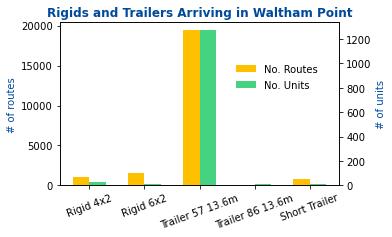

In [4]:
# Number of routes and units
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
site_routes = routes_cleaned[routes_cleaned['site_id_end'] == 1]
grouped = site_routes.groupby('spec_id').agg({'vehicle_id': 'nunique', 'route_id': 'count'})
fig, ax = plt.subplots(
    1, figsize=(5, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    f'Rigids and Trailers Arriving in Waltham Point',
    color=FPS_COLOURS[0], fontweight='bold')
x = np.arange(len(good_specs))
ax.bar(x=x-0.15, width=0.3,
       height=grouped['route_id'], color=FPS_COLOURS[2], label='No. Routes')
ax2 = ax.twinx()
ax2.bar(x=x+0.15, width=0.3,
       height=grouped['vehicle_id'], color=FPS_COLOURS[1], label='No. Units')
ax.set_ylabel('# of routes', color=FPS_COLOURS[0])
ax2.set_ylabel('# of units', color=FPS_COLOURS[0])
ax.set_xticks(x, labels=grouped.index.map(good_specs))
ax.set_xticklabels(labels=grouped.index.map(good_specs), rotation = 20)
ax.legend(frameon=False, bbox_to_anchor=(0.6, 0.8))
ax2.legend(frameon=False, bbox_to_anchor=(0.6, 0.7))
fig.savefig(
    f"sample/tru2/wp_routes_per_group.png",
    bbox_inches="tight", dpi=300)

In [5]:
route_feasibility = routes_cleaned.groupby(['spec_id', 'battery_choice'])['site_id_start'].count()
route_feasibility = route_feasibility.unstack().fillna(0)
route_feasibility.index = route_feasibility.index.map(good_specs)
total_routes = route_feasibility.sum(axis=1).values[:, None]

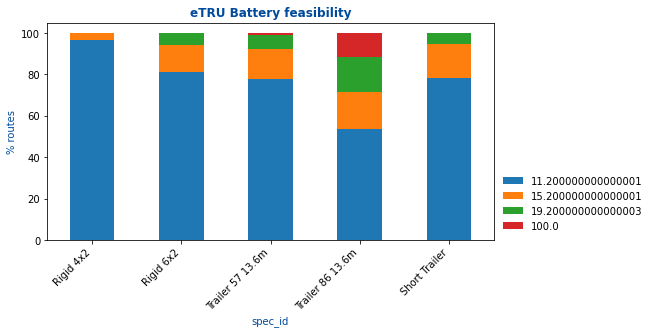

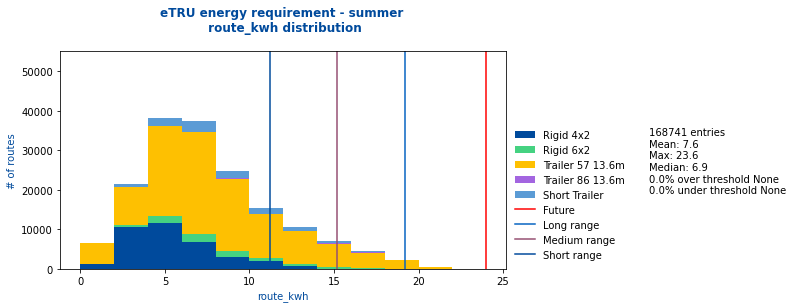

In [6]:
season = 'summer'

ff.plot_stacked_bar(route_feasibility/total_routes*100, folder='tru2', x_axis='spec_id',
                 title_text='eTRU Battery feasibility', site_name='all',
                 y_axis=r'% routes', suff=f'_{season}')
ff.plot_grouped_histo(routes_cleaned, 'route_kwh', specs, 'spec_id', good_specs,
                   folder='tru2', site_name='all',
                   bins=np.arange(0,26, step=2),
                   title_text=f'eTRU energy requirement - {season}',
                   vline_dict=tru_battery_dict, plot_mean=False,
                   suff=f'_{season}', ylim=[0, 55000])

In [29]:
max_unique_veh = routes_cleaned.groupby('site_id_end')[['vehicle_id']].nunique().loc[good_sites]
max_unique_veh['site_name'] = max_unique_veh.index.map(site_dict)
max_unique_veh

,vehicle_id,site_name
site_id_end,,
1,1334,Waltham Point DC
2,1322,Northampton DC
3,1224,Basingstoke DC
4,1222,Hams Hall DC
5,1292,Dartford DC
6,1080,Sherburn DC
7,1034,Haydock DC
8,1067,Emerald Park DC
9,691,Langlands Park DC


In [24]:
departures_per_day = routes_cleaned.groupby(['site_id_start', 'date'])[['route_id']].count()
max_daily_departures = departures_per_day.groupby('site_id_start').max()
max_daily_departures['site_name'] = max_daily_departures.index.map(site_dict)
max_daily_departures.loc[good_sites]

,route_id,site_name
site_id_start,,
1,363,Waltham Point DC
2,251,Northampton DC
3,268,Basingstoke DC
4,267,Hams Hall DC
5,321,Dartford DC
6,238,Sherburn DC
7,226,Haydock DC
8,178,Emerald Park DC
9,147,Langlands Park DC


In [34]:
routes_cleaned.columns

Index(['site_id_start', 'departure_time', 'arrival_time', 'vehicle_id',
       'distance_miles', 'route_id', 'number_order', 'driving_time',
       'site_id_end', 'source', 'spec_id', 'good_site', 'site_ids',
       'same_return', 'start_right_id', 'duration_hours', 'date', 'start_time',
       'end_time', 'last_wait_onsite', 'next_wait_onsite', 'week',
       'edge_routes', 'route_kwh', 'shorepower_time', 'shorepower_kwh',
       'recharge_power_kw', 'battery_choice'],
      dtype='object')

In [9]:
((routes_cleaned['route_kwh'] / (routes_cleaned['next_wait_onsite'] - 1/4)) > 9* 0.9).mean()

0.00961829075328462

In [11]:
routes_cleaned.columns

Index(['site_id_start', 'departure_time', 'arrival_time', 'vehicle_id',
       'distance_miles', 'route_id', 'number_order', 'driving_time',
       'site_id_end', 'source', 'spec_id', 'good_site', 'site_ids',
       'same_return', 'start_right_id', 'duration_hours', 'date', 'start_time',
       'end_time', 'last_wait_onsite', 'next_wait_onsite', 'week',
       'edge_routes', 'route_kwh', 'shorepower_time', 'shorepower_kwh',
       'recharge_power_kw', 'battery_choice'],
      dtype='object')

In [12]:
routes_cleaned.groupby('spec_id')['vehicle_id'].nunique()

spec_id
101     345
102      86
115    1513
116      19
117     177
Name: vehicle_id, dtype: int64

In [13]:
345+86

431

## Other

### Count vehicles

In [ ]:
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
routes_cleaned.groupby('spec_id')['vehicle_id'].nunique()

### Weekly energy

In [9]:
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
site_arrivals = routes_cleaned[routes_cleaned['site_id_end'].isin(good_sites)]
weekly_usage = site_arrivals.groupby(['week']).agg({
    'route_kwh': 'sum',
    'shorepower_kwh': 'sum',
    'route_id': 'count',
    'vehicle_id': 'nunique'})
weekly_usage['total_kwh_tru'] = weekly_usage['route_kwh']*0.72753923 + weekly_usage['shorepower_kwh']*0.639393939
weekly_usage.columns = ['route_kwh', 'shorepower_kwh', 'n_routes', 'n_vehicles', 'total_kwh_tru']
weekly_usage.to_csv('sample/tru2/durations_all.csv')

### Count routes per day

In [6]:
routes_cleaned = pickle.load(open('sample/tru/routes_cleaned.pkl', 'rb'))
trailer_routes = routes_cleaned[routes_cleaned['spec_id'] == 115]
trailer_routes.groupby(['vehicle_id', 'date']).count().mean()['site_id_start']
trailer_routes.groupby('vehicle_id').count()['site_id_start'].median()
# trailer_routes

78.0

In [7]:
route_vehicles = routes_cleaned['vehicle_id'].unique()
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
cnx = dbh.create_alch_engine()
vehicle_df = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()
vehicle_df['client_vehicle_id'] = vehicle_df['client_vehicle_id'].astype(str)
vehicle_df['refrigerated'] = vehicle_df['refrigerated'].astype(bool)
hgv_assets = pd.read_excel(
    r"C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\22-03.SSL.depot_asset_register.MA.02.xlsx",
    usecols=['Fleet Category', 'Fleet Reg No', 'Site',
       'Fleet Classification', 'Fleet Status', 'Fridge Make Model',
       'Fridge Manufacturer', 'Vehicle Description', 'Vehicle Group'])
hgv_assets['Fleet Reg No'] = hgv_assets['Fleet Reg No'].astype(str)
vehicle_df = vehicle_df.merge(hgv_assets, left_on='client_vehicle_id', right_on='Fleet Reg No', how='left')
vehicle_df = vehicle_df[vehicle_df['spec_id'].isin(good_specs)].set_index('vehicle_id')
vehicle_df = vehicle_df.loc[route_vehicles]


In [8]:
vehicle_df[~vehicle_df['refrigerated']].index

Int64Index([127, 725, 726, 727, 728, 729, 731, 733, 735, 738, 739, 741, 742,
            743, 745, 748, 749, 750, 752, 755, 756, 758, 759, 760, 763, 764,
            769, 770, 771],
           dtype='int64', name='vehicle_id')

In [12]:
bad_vehicles = [127, 725, 726, 727, 728, 729, 731, 733, 735, 738, 739, 741, 742, 743, 745, 748, 749, 750, 752, 755, 756, 758, 759, 760, 763, 764, 769, 770, 771]
routes_cleaned_new = routes_cleaned[~routes_cleaned['vehicle_id'].isin(bad_vehicles)]
pickle.dump(routes_cleaned_new, open('sample/tru2/routes_cleaned_new.pkl', 'wb'))

### Vehicle/trailer refrigeration
Update vehicle specification table with a boolean refrigeration column

In [ ]:
mask = telematics['spec_id'].isin([101, 102, 103, 104])
location_count = telematics[mask].groupby('departure_location').agg({
    'vehicle_id': 'count',
    'distance_miles': 'sum'}).sort_values(by='vehicle_id')
location_count['depot or argos'] = (location_count.index.str.contains('DC')
                                    | location_count.index.str.contains('Argos')
                                    | location_count.index.str.contains('NFT')
                                    | location_count.index.str.contains('RRU')
                                    | location_count.index.str.contains('VMU'))
location_count[location_count['depot or argos']].sort_values(by='vehicle_id').to_csv('sample/tru2/count_entries.csv')

In [ ]:
# Load asset register with fleet category and fridge
hgv_assets = pd.read_excel(
    r"C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\22-03.SSL.depot_asset_register.MA.02.xlsx",
    usecols=['Fleet Category', 'Fleet Reg No',
       'Fleet Classification', 'Fleet Status', 'Fridge Make Model',
       'Fridge Manufacturer', 'Vehicle Description', 'Vehicle Group'])
hgv_assets['Fleet Reg No'] = hgv_assets['Fleet Reg No'].astype(str)
# Merge with the databaase vehicle list
vehicle_df = pd.read_csv('sample/tru2/t_vehicles_orig.csv')
vehicle_df['client_vehicle_id'] = vehicle_df['client_vehicle_id'].astype(str)
vehicle_df = vehicle_df.merge(hgv_assets, left_on='client_vehicle_id', right_on='Fleet Reg No', how='left')
vehicle_df = vehicle_df[vehicle_df['spec_id'].isin(good_specs)]

# Identify all the vehicles/trailers that are refrigerated
ref_description = vehicle_df['Vehicle Description'].str.split('/').str[0]
ref_description.unique()
vehicle_df.loc[ref_description == 'AMB', 'refrigerated'] = False
vehicle_df.loc[ref_description.isin(['REF2T', 'REF3T', 'REF1T']), 'refrigerated'] = True
# Store
pickle.dump(vehicle_df, open('sample/tru2/vehicle_list270722-2.pkl', 'wb'))
# Upload the database
cols = ['vehicle_id', 'client_id', 'site_id', 'client_vehicle_id', 'tru_id', 'spec_id',
       'registration', 'refrigerated']
dbh.upload_table(vehicle_df[cols], 't_vehicles')

### Count location entries

In [ ]:
mask = telematics['spec_id'].isin([101, 102, 103, 104])
location_count = telematics[mask].groupby('departure_location').agg({
    'vehicle_id': 'count',
    'distance_miles': 'sum'}).sort_values(by='vehicle_id')
location_count['depot or argos'] = (location_count.index.str.contains('DC')
                                    | location_count.index.str.contains('Argos')
                                    | location_count.index.str.contains('NFT')
                                    | location_count.index.str.contains('RRU')
                                    | location_count.index.str.contains('VMU'))
location_count[location_count['depot or argos']].sort_values(by='vehicle_id').to_csv('sample/tru2/count_entries.csv')

### Telematics statistics

In [15]:
cnx = dbh.create_alch_engine()
sql_query = """SELECT vehicle_id, distance_miles, arrival_site_id, route_id
    FROM t_telematics WHERE run = 44"""
telematics = pd.read_sql_query(sql_query, con=cnx)
telematics['spec_id'] = telematics['vehicle_id'].map(vehicle_spec_dict)
telematics = telematics.merge(vehicle_df[['refrigerated']], left_on='vehicle_id', right_index=True, how='left')

In [24]:
# Get distance for non-refrigerated rigids
mask_refrigerated = telematics['refrigerated']
mask_spec = telematics['spec_id'].isin([101, 102])
print('Rigids:', telematics[mask_spec & mask_refrigerated]['distance_miles'].sum())
# Select only tractors 
mask_spec = telematics['spec_id'].isin([103, 104])
print('Tractors:', telematics[mask_spec]['distance_miles'].sum())

Rigids: 1760504.8663766317
Tractors: 7450721.870727163


In [22]:
hgv_allocations = [444, 445, 446, 447, 466, 467, 484, 485, 486, 487, 544, 545, 546, 547, 454, 455,
                   456, 457, 474, 475, 476, 477, 504, 505, 506, 507, 434, 435, 436, 437, 516, 517,
                   424, 425, 426, 427, 534, 535, 536, 414, 415, 416, 417]
sql_query = f"""SELECT allocation_id, route_id, allocated_vehicle_id
    FROM t_route_allocated WHERE allocation_id IN {tuple(hgv_allocations)}"""
routes = pd.read_sql_query(sql_query, con=cnx)
# sql_query = f"""SELECT route_id, distance_miles
#     FROM t_route_master WHERE route_id IN {tuple(routes['route_id'])}"""
# routes_distance = pd.read_sql_query(sql_query, con=cnx)

In [25]:
routes['allocated_vehicle_id'].nunique()

1100

In [34]:
sql_query = f"""SELECT route_id, vehicle_id
    FROM t_route_master WHERE client_id=3"""
routes_distance = pd.read_sql_query(sql_query, con=cnx)
routes_distance = routes_distance.merge(vehicle_df[['spec_id']],
                      left_on='vehicle_id', right_index=True, how='left')
mask_spec = routes_distance['spec_id'].isin([101, 102, 103, 104])
routes_distance.loc[mask_spec, 'vehicle_id'].nunique()

1313

### TRU energy usage

In [18]:
# Load route data
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
# Calculate eTRU energy per site
df = routes_cleaned.groupby(['site_id_end'])[['shorepower_kwh', 'route_kwh']].sum()
df['site_name'] = df.index.map(site_dict)
# Convert to daily amount
df['daily_kwh_summer'] = (df['shorepower_kwh'] + df['route_kwh'])/78
df.to_csv('sample/tru2/tru_consumption_kwh.csv')

### Back up charge demand

In [3]:

connection, cur = dbh.database_connection('test')
for i in [1021, 1031, 1041, 1051]:
    sql_query =  f"select * from t_charge_demand where scenario_id >= {i} and scenario_id < {i+10}"
    cur.execute(sql_query)
    connection.commit()
    charge_demand = cur.fetchall()
    pickle.dump(charge_demand, open(f'sample/tru2/backups_220702/t_charge_demand{i}.pkl', 'wb'))

## Peak Demand

### Waltham Point max demand

In [17]:
scenarios = (1169, 1170, 1171,1172, 1173)
combined_scenario = 1245
chargign_scenarios = [1001, 1002, 1003, 1004, 1005]
sql_query = f"SELECT * FROM t_charge_demand where scenario_id IN {tuple([combined_scenario] + chargign_scenarios)}"
cnx = dbh.create_alch_engine()
demand = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

In [18]:
tru_demand = demand.groupby('datetime').sum()
tru_demand['power_demand_kw'].max()

1124.1325669817763